In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt

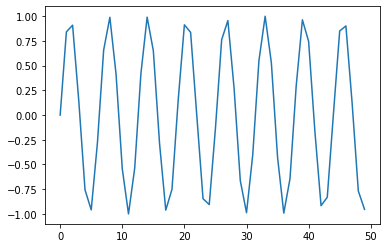

In [43]:
sin_wave = np.array([math.sin(x) for x in np.arange(200)])
plt.plot(sin_wave[:50])

In [44]:
X = []
Y = []
seq_len = 50
num_records = len(sin_wave) - seq_len

for i in range(num_records-50):
    X.append(sin_wave[i:i+seq_len])
    Y.append(sin_wave[i+seq_len])
    
X = np.array(X)
Y = np.array(Y)

X = np.expand_dims(X,axis=2)
Y = np.expand_dims(Y,axis=1)

In [45]:
X.shape, Y.shape

((100, 50, 1), (100, 1))

In [46]:
X_val = []
Y_val = []

for i in range(num_records-50, num_records):
    X_val.append(sin_wave[i:i+seq_len])
    Y_val.append(sin_wave[i+seq_len])
    
X_val = np.array(X_val)
Y_val = np.array(Y_val)

X_val = np.expand_dims(X_val, axis=2)
Y_val = np.expand_dims(Y_val, axis=1)

In [47]:
# Architecture for RNN

learning_rate = 0.0001
nepoch = 25
T = 50 # length of sequence
hidden_dim = 100
output_dim = 1

bptt_truncate = 5
min_clip_value = -10
max_clip_value = 10

In [48]:
# define weights of network
U = np.random.uniform(0,1,(hidden_dim, T)) # weights input and hidden layers
W = np.random.uniform(0,1,(hidden_dim,hidden_dim)) # weights hidden ouput layers
V = np.random.uniform(0,1,(output_dim,hidden_dim)) # shared weights in RNN layer

In [49]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [50]:
# Train the model

# check the loss on training data
for epoch in range(nepoch):
    loss = 0.0
    # do a forward pass to get prediction
    for i in range(Y.shape[0]):
        x,y = X[i],Y[i]
        prev_s = np.zeros((hidden_dim,1))  # here, prev-s is the value of the previous activation of hidden layer; which is initialized as all zeroes
        for t in range(T):
            new_input = np.zeros(x.shape) # we do forward pass for every timestep in sequence
            new_input[t] = x[t] # define single input for that timestep
            mulu = np.dot(U,new_input)
            mulw = np.dot(W,prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V,s)
            prev_s = s
            
        # calculate error
        loss_per_record = (y-mulv)**2/2
        loss += loss_per_record
    loss = loss/float(y.shape[0])
    
    # check the loss on validation data
    val_loss = 0.0
    for i in range(Y_val.shape[0]):
        x,y = X_val[i], Y_val[i]
        prev_s = np.zeros((hidden_dim,1))
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U,new_input)
            mulw = np.dot(W,prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V,s)
            prev_s = s
        
        loss_per_record = (y-mulv)**2/2
        val_loss += loss_per_record
    val_loss = val_loss/ float(y.shape[0])
    print('Epoch: ', epoch+1, ', Loss: ', loss, ', Val Loss: ', val_loss)
    
    # Start actual training
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]
    
        layers = []
        prev_s = np.zeros((hidden_dim, 1))
        dU = np.zeros(U.shape)
        dV = np.zeros(V.shape)
        dW = np.zeros(W.shape)
        
        dU_t = np.zeros(U.shape)
        dV_t = np.zeros(V.shape)
        dW_t = np.zeros(W.shape)
        
        dU_i = np.zeros(U.shape)
        dW_i = np.zeros(W.shape)
        
        # forward pass
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            layers.append({'s':s, 'prev_s':prev_s})
            prev_s = s
            
        # derivative of pred
        dmulv = (mulv - y)
        
        # backward pass
        for t in range(T):
            dV_t = np.dot(dmulv, np.transpose(layers[t]['s']))
            dsv = np.dot(np.transpose(V), dmulv)
            
            ds = dsv
            dadd = add * (1 - add) * ds
            
            dmulw = dadd * np.ones_like(mulw)

            dprev_s = np.dot(np.transpose(W), dmulw)


            for i in range(t-1, max(-1, t-bptt_truncate-1), -1):
                ds = dsv + dprev_s
                dadd = add * (1 - add) * ds

                dmulw = dadd * np.ones_like(mulw)
                dmulu = dadd * np.ones_like(mulu)

                dW_i = np.dot(W, layers[t]['prev_s'])
                dprev_s = np.dot(np.transpose(W), dmulw)

                new_input = np.zeros(x.shape)
                new_input[t] = x[t]
                dU_i = np.dot(U, new_input)
                dx = np.dot(np.transpose(U), dmulu)

                dU_t += dU_i
                dW_t += dW_i
                
            dV += dV_t
            dU += dU_t
            dW += dW_t
            
            # Update weights
            if dU.max() > max_clip_value:
                dU[dU > max_clip_value] = max_clip_value
            if dV.max() > max_clip_value:
                dV[dV > max_clip_value] = max_clip_value
            if dW.max() > max_clip_value:
                dW[dW > max_clip_value] = max_clip_value
                
            
            if dU.min() < min_clip_value:
                dU[dU < min_clip_value] = min_clip_value
            if dV.min() < min_clip_value:
                dV[dV < min_clip_value] = min_clip_value
            if dW.min() < min_clip_value:
                dW[dW < min_clip_value] = min_clip_value
        
        # update
        U -= learning_rate * dU
        V -= learning_rate * dV
        W -= learning_rate * dW

Epoch:  1 , Loss:  [[119914.89888747]] , Val Loss:  [[59955.52086007]]
Epoch:  2 , Loss:  [[75947.56877013]] , Val Loss:  [[37972.24157546]]
Epoch:  3 , Loss:  [[41980.23865258]] , Val Loss:  [[20988.96229075]]
Epoch:  4 , Loss:  [[18012.90612522]] , Val Loss:  [[9005.68180015]]
Epoch:  5 , Loss:  [[4026.39648251]] , Val Loss:  [[2012.80592407]]
Epoch:  6 , Loss:  [[46.59129831]] , Val Loss:  [[23.25773766]]
Epoch:  7 , Loss:  [[24.91643512]] , Val Loss:  [[12.42252639]]
Epoch:  8 , Loss:  [[24.93819884]] , Val Loss:  [[12.4318274]]
Epoch:  9 , Loss:  [[25.05789706]] , Val Loss:  [[12.48923626]]
Epoch:  10 , Loss:  [[24.82646694]] , Val Loss:  [[12.3770926]]
Epoch:  11 , Loss:  [[25.05937627]] , Val Loss:  [[12.49081006]]
Epoch:  12 , Loss:  [[25.04425797]] , Val Loss:  [[12.48666136]]
Epoch:  13 , Loss:  [[24.77825273]] , Val Loss:  [[12.35471596]]
Epoch:  14 , Loss:  [[25.39464018]] , Val Loss:  [[12.65326874]]
Epoch:  15 , Loss:  [[24.85229765]] , Val Loss:  [[12.38752933]]
Epoch:  

In [51]:
# get predictions

preds = []
for i in range(Y.shape[0]):
    x,y = X[i],Y[i]
    prev_s = np.zeros((hidden_dim,1))
    #forward pass
    for t in range(T):
        mulu = np.dot(U,x)
        mulw = np.dot(W,prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V,s)
        prev_s = s
        
    preds.append(mulv)

preds = np.array(preds)

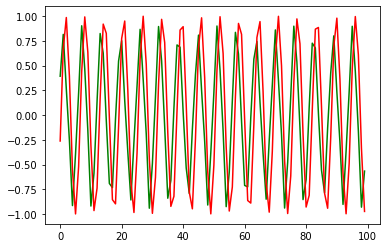

In [52]:
plt.plot(preds[:,0,0],'g')
plt.plot(Y[:,0],'r')
plt.show()

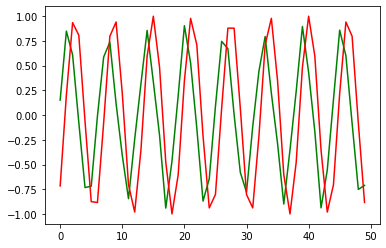

In [53]:
preds = []
for i in range(Y_val.shape[0]):
    x, y = X_val[i], Y_val[i]
    prev_s = np.zeros((hidden_dim, 1))
    # For each time step...
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y_val[:, 0], 'r')
plt.show()